## Unit 3: Spatial Data

### Learning objectives
This module provides an introduction to the fundamentals of working with spatial vector and raster data in python while empirically exploring why systematic and structural racism is interwined with urban ecological processes.

### Background 

In August 2020, [Christopher Schell](http://directory.tacoma.uw.edu/employee/cjschell) and collegues published a review in *Science* on ['The ecological and evolutionary consequences of systemic racism in urban environments'](https://science.sciencemag.org/content/early/2020/08/12/science.aay4497) (DOI: 10.1126/science.aay4497), showing how systematic racism and classism  has significant impacts on ecological and evolutionary processes within urban environments. Here we explore a subset of the data used to support these findings in this review and the broader literature.

The [press release](https://www.washington.edu/news/2020/08/13/systemic-racism-has-consequences-for-all-life-in-cities/) on the paper is worth a read:

> “Racism is destroying our planet, and how we treat each other is essentially structural violence against our natural world,” said lead author Christopher Schell, an assistant professor of urban ecology at the University of Washington Tacoma. “Rather than just changing the conversation about how we treat each other, this paper will hopefully change the conversation about how we treat the natural world.”

In the paper, Schell writes: 

 > "In multiple cases, neighborhood racial composition can be a stronger predictor of urban socio-ecological patterns than wealth."

We are going to explore one metric for how structural racism and classism underpin landscape heterogeneity in cities.

**Figure 2** in the Schell paper shows how NDVI (Normalized Difference Vegetation Index) tracks historical redlining.

```{image} attachment:23647e95-a23c-4eb8-a9bb-f0c91e45c1ac.png
:width: 300px
:align: center
```
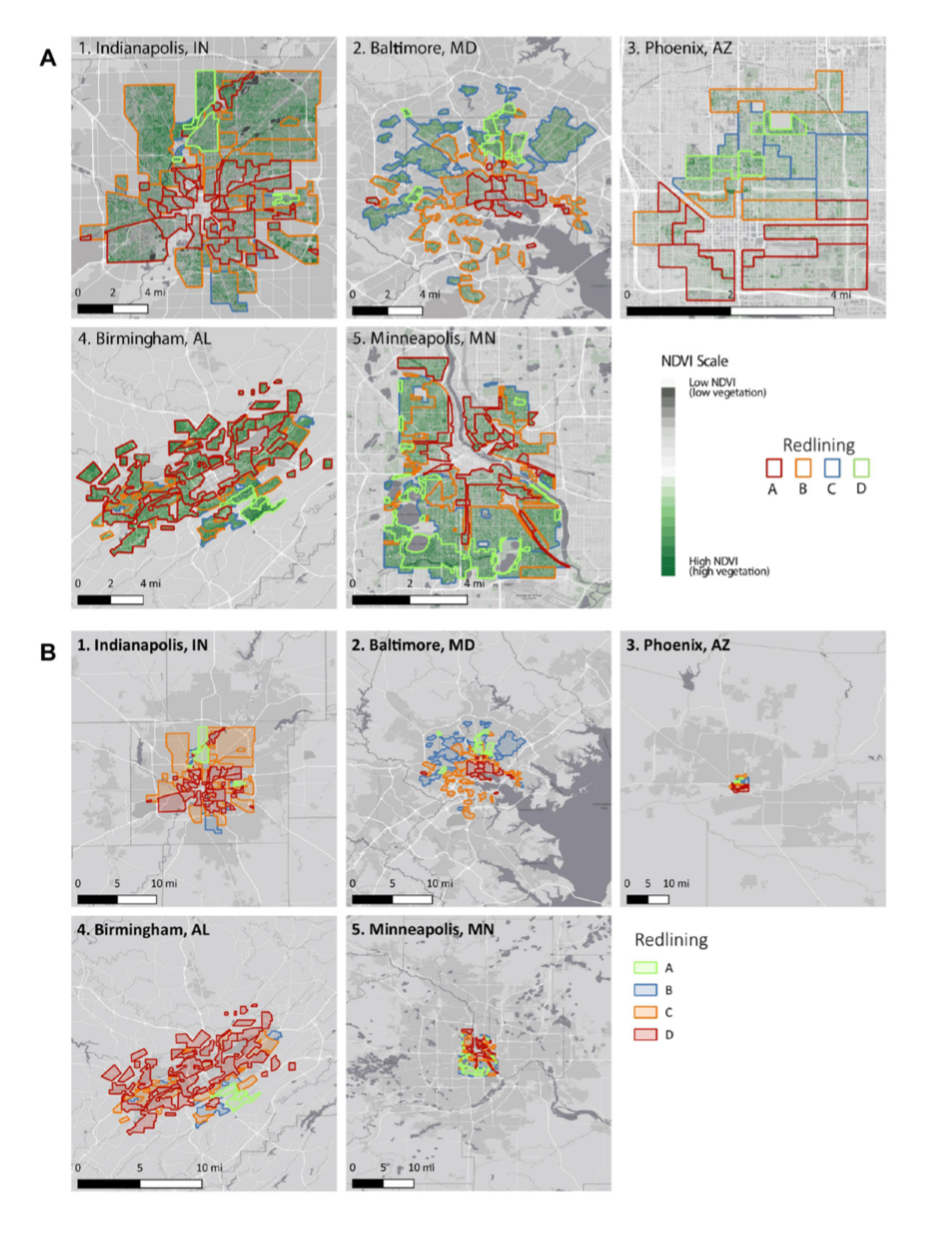

We are going to recreate some of these city maps, and plot the distributions and mean vegetation patterns across cities to explore the structural inequality and racism that Schell et al highlight in their paper.


To do this we are going to use the following spatial data:  

**1. Mapping Inequality:** (vector data)  
Please take the time to read the introduction to this dataset [here](https://dsl.richmond.edu/panorama/redlining/#loc=3/41.245/-105.469&text=intro)

**2.  Satellite Imagery from Sentinel-2 catalog:** (raster data), from [Planetary Computer](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a)

In [2]:
from IPython.display import IFrame

In [3]:
import ibis
from ibis import _
con = ibis.duckdb.connect(extensions=["spatial"])

In [4]:
# slow
redlines = con.read_geo("/vsicurl/https://dsl.richmond.edu/panorama/redlining/static/mappinginequality.gpkg")
redlines.to_parquet("redlines.parquet")

In [5]:
redlines_local = con.read_parquet("redlines.parquet")

In [6]:
redlines.columns

['area_id',
 'city',
 'state',
 'city_survey',
 'category',
 'grade',
 'label',
 'residential',
 'commercial',
 'industrial',
 'fill',
 'geom']

In [7]:
redlines.select(_.city).distinct().head(10).execute() 

city
0         Chicago
1  East St. Louis
2     Springfield
3      Fort Wayne
4          Muncie
5      Louisville
6       Cambridge
7         Chelsea
8          Dedham
9       Haverhill

In [8]:
city = (redlines_local
        .filter(_.city == "New Haven")
        .execute()
       )

In [9]:
city = (con
    .read_geo("/vsicurl/https://dsl.richmond.edu/panorama/redlining/static/mappinginequality.gpkg")
    .filter(_.city == "New Haven")
    .execute()
)

In [10]:
city = redlines.filter(_.city == "New Haven")

In [11]:
city_gdf = city.head().execute()
city_gdf

area_id       city state  city_survey category grade label  residential  \
0     3569  New Haven    CT         True     Best     A    A1         True   
1     3568  New Haven    CT         True     Best     A    A2         True   
2     3566  New Haven    CT         True     Best     A    A3         True   
3     3567  New Haven    CT         True     Best     A    A4         True   
4     3564  New Haven    CT         True     Best     A    A5         True   

   commercial  industrial     fill  \
0       False       False  #76a865   
1       False       False  #76a865   
2       False       False  #76a865   
3       False       False  #76a865   
4       False       False  #76a865   

                                                geom  
0  MULTIPOLYGON (((-72.90000 41.36885, -72.90325 ...  
1  MULTIPOLYGON (((-72.89401 41.36331, -72.89256 ...  
2  MULTIPOLYGON (((-72.90981 41.35949, -72.90284 ...  
3  MULTIPOLYGON (((-72.90284 41.35795, -72.89990 ...  
4  MULTIPOLYGON (((-72.89801 41.34930, -72.89883 ...

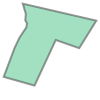

In [12]:
city_gdf.geom[3]

In [13]:
str(city_gdf.geom[3])

'MULTIPOLYGON (((-72.90284 41.35795, -72.8999 41.35712, -72.89788 41.36147, -72.89564 41.36069, -72.89401 41.36331, -72.90102 41.36493, -72.90073 41.36396, -72.90078 41.36333, -72.90062 41.36305, -72.90069 41.36266, -72.90132 41.36172, -72.90178 41.36076, -72.90284 41.35795)))'

In [14]:
city = (redlines
        .filter(_.city == "New Haven")
        .mutate(area = _.geom.area())
       )

In [15]:
import ibis
from ibis import _
con = ibis.duckdb.connect()

city = (con
    .read_geo("/vsicurl/https://dsl.richmond.edu/panorama/redlining/static/mappinginequality.gpkg")
    .filter(_.city == "New Haven")
    .execute()
)

In [16]:
import leafmap.maplibregl as leafmap

m = leafmap.Map(style="positron")
m.add_gdf(city)
m

Map(height='600px', map_options={'bearing': 0, 'center': (0, 20), 'pitch': 0, 'style': 'https://basemaps.carto…

In [17]:
m.to_html("docs/new_haven.html", overwrite = True)

# display map on course website by using an iframe to the output URL 
IFrame(src='https://espm-157.github.io/static-maps/nh1.html', width=700, height=400)

In [18]:
import ibis
from ibis import _
con = ibis.duckdb.connect(extensions=["spatial"])

redlines = (
    con
    .read_geo("/vsicurl/https://dsl.richmond.edu/panorama/redlining/static/mappinginequality.gpkg")
    .filter(_.city == "New Haven", _.residential)
   )
city =  redlines.execute()
box = city.total_bounds
box

array([-72.99321,  41.23109, -72.85227,  41.37502])

In [19]:
from pystac_client import Client
import odc.stac
import rioxarray

 
items = (Client.open("https://earth-search.aws.element84.com/v1").search(collections = ['sentinel-2-l2a'], bbox = box, datetime = "2022-06-01/2022-08-01", query={"eo:cloud_cover": {"lt": 20}}).item_collection())

In [20]:
data = odc.stac.load(
    items,
    bands=["nir08", "red"],
    bbox=box
)

In [21]:
ndvi = (
    (data.nir08 - data.red) / (data.nir08 + data.red)
    .compute()
)

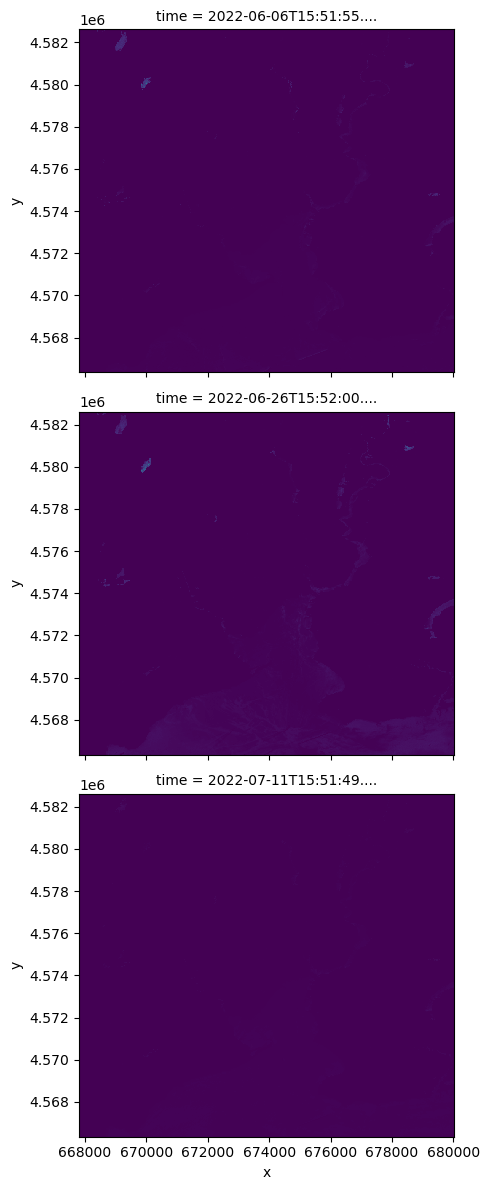

In [22]:
import matplotlib as plt
cmap = plt.colormaps.get_cmap('viridis')  # viridis is the default colormap for imshow
cmap.set_bad(color='black')
ndvi.plot.imshow(row="time", cmap=cmap, add_colorbar=False, size=4)

In [25]:
import leafmap.maplibregl as leafmap

paint = {
    "fill-color": ["get", "fill"],
    "fill-opacity": 0.8,
    "fill-outline-color": "#ffffff",
}

m = leafmap.Map(center=[-120, 38], zoom=5, style="positron")
m = m.add_basemap("OpenStreetMap")
m = m.add_gdf(city, layer_type = "fill", name="Redlining", paint=paint)
m.to_html("docs/index.html", overwite=True)
m

AttributeError: 'NoneType' object has no attribute 'add_gdf'

In [26]:
from pystac_client import Client

In [27]:
items = (
  Client.
  open("https://earth-search.aws.element84.com/v1").
  search(
    collections = ['sentinel-2-l2a'],
    bbox = box,
    datetime = "2024-06-01/2024-09-01",
    query={"eo:cloud_cover": {"lt": 20}}).
  item_collection()
)

In [28]:
items

In [29]:
import odc.stac

In [30]:
data = odc.stac.load(
    items,
    bands=["nir08", "red"],
    bbox=box,
    resolution=10, # the native resolution is already 10m.  Increase this to ~ 100m for larger cities.
    groupby="solar_day",
    chunks = {} # this tells odc to use dask
    
)

data

<xarray.Dataset> Size: 32MB
Dimensions:      (y: 1627, x: 1220, time: 4)
Coordinates:
  * y            (y) float64 13kB 4.583e+06 4.583e+06 ... 4.566e+06 4.566e+06
  * x            (x) float64 10kB 6.678e+05 6.678e+05 ... 6.8e+05 6.8e+05
    spatial_ref  int32 4B 32618
  * time         (time) datetime64[ns] 32B 2024-06-15T15:51:53.600000 ... 202...
Data variables:
    nir08        (time, y, x) uint16 16MB dask.array<chunksize=(1, 1627, 1220), meta=np.ndarray>
    red          (time, y, x) uint16 16MB dask.array<chunksize=(1, 1627, 1220), meta=np.ndarray>

In [31]:
ndvi = (
    ((data.nir08 - data.red) / (data.red + data.nir08))
    .median("time", keep_attrs=True)
)

ndvi = ndvi.where(ndvi < 1).compute()

In [32]:
ndvi

<xarray.DataArray (y: 1627, x: 1220)> Size: 16MB
array([[0.88591885, 0.88051675, 0.87161283, ..., 0.85875371, 0.84881165,
        0.86324397],
       [0.85873743, 0.88231669, 0.90861641, ..., 0.75906042, 0.82126435,
        0.84697593],
       [0.84439895, 0.88673668, 0.89681533, ..., 0.77134877, 0.82810371,
        0.84242071],
       ...,
       [0.81399746, 0.45830669, 0.36016143, ...,        nan,        nan,
               nan],
       [0.8458809 , 0.48283024, 0.41006737, ...,        nan,        nan,
               nan],
       [0.82337862, 0.4601535 , 0.44678909, ...,        nan,        nan,
               nan]])
Coordinates:
  * y            (y) float64 13kB 4.583e+06 4.583e+06 ... 4.566e+06 4.566e+06
  * x            (x) float64 10kB 6.678e+05 6.678e+05 ... 6.8e+05 6.8e+05
    spatial_ref  int32 4B 32618

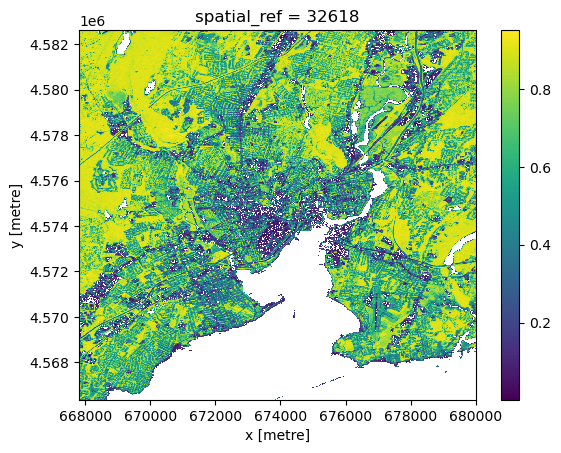

In [33]:
ndvi.plot.imshow()

In [34]:
import rioxarray
(ndvi
 .rio.reproject("EPSG:4326")
 .rio.to_raster(raster_path="ndvi.tif", 
                driver="COG")   
)

In [35]:
# city.to_file("new_haven.shp") # common legacy format, not ideal
# city.to_file("new_haven.gpkg") # Good open standard

# latest option, best performance but less widely known:
city.to_parquet("new_haven.parquet")

In [36]:
city = city.set_crs("EPSG:4326")

In [37]:
import exactextract

stats = exactextract.exact_extract("ndvi.tif", 
                                   city, 
                                   "mean", 
                                   output = "pandas", 
                                   include_cols = ["category", "label", "fill"],
                                   include_geom = True)
stats.to_parquet("boston_stats.parquet")

In [38]:
con.read_parquet("boston_stats.parquet").execute()

category label     fill      mean  \
0                   Best    A1  #76a865  0.709624   
1                   Best    A2  #76a865  0.761685   
2                   Best    A3  #76a865  0.665130   
3                   Best    A4  #76a865  0.751388   
4                   Best    A5  #76a865  0.742981   
5                   Best    A6  #76a865  0.785301   
6                   Best    A7  #76a865  0.724686   
7                   Best    A8  #76a865  0.705690   
8        Still Desirable    B1  #7cb5bd  0.705894   
9        Still Desirable   B10  #7cb5bd  0.528606   
10       Still Desirable    B2  #7cb5bd  0.686820   
11       Still Desirable    B3  #7cb5bd  0.659411   
12       Still Desirable    B4  #7cb5bd  0.630884   
13       Still Desirable    B5  #7cb5bd  0.657049   
14       Still Desirable    B6  #7cb5bd  0.607181   
15       Still Desirable    B7  #7cb5bd  0.659647   
16       Still Desirable    B8  #7cb5bd  0.400644   
17       Still Desirable    B9  #7cb5bd  0.557100   
18  Definitely Declining    C1  #ffff00  0.623442   
19  Definitely Declining   C10  #ffff00  0.413014   
20  Definitely Declining   C11  #ffff00  0.498510   
21  Definitely Declining   C12  #ffff00  0.592631   
22  Definitely Declining   C13  #ffff00  0.637532   
23  Definitely Declining   C14  #ffff00  0.581926   
24  Definitely Declining   C15  #ffff00  0.469258   
25  Definitely Declining   C16  #ffff00  0.529362   
26  Definitely Declining   C17  #ffff00  0.572002   
27  Definitely Declining   C18  #ffff00  0.705424   
28  Definitely Declining   C19  #ffff00  0.515124   
29  Definitely Declining    C2  #ffff00  0.520958   
30  Definitely Declining   C20  #ffff00  0.613976   
31  Definitely Declining    C3  #ffff00  0.517923   
32  Definitely Declining    C4  #ffff00  0.476773   
33  Definitely Declining    C5  #ffff00  0.590507   
34  Definitely Declining    C6  #ffff00  0.555413   
35  Definitely Declining    C7  #ffff00  0.460538   
36  Definitely Declining    C8  #ffff00  0.528327   
37  Definitely Declining    C9  #ffff00  0.541925   
38             Hazardous    D1  #d9838d  0.586929   
39             Hazardous    D2  #d9838d  0.572568   
40             Hazardous    D3  #d9838d  0.412199   
41             Hazardous    D4  #d9838d  0.478985   
42             Hazardous    D5  #d9838d  0.435876   
43             Hazardous    D6  #d9838d  0.367980   
44             Hazardous    D7  #d9838d  0.613559   
45             Hazardous    D8  #d9838d  0.505079   
46             Hazardous    D9  #d9838d  0.406590   

                                             geometry  
0   MULTIPOLYGON (((-72.90000 41.36885, -72.90325 ...  
1   MULTIPOLYGON (((-72.89401 41.36331, -72.89256 ...  
2   MULTIPOLYGON (((-72.90981 41.35949, -72.90284 ...  
3   MULTIPOLYGON (((-72.90284 41.35795, -72.89990 ...  
4   MULTIPOLYGON (((-72.89801 41.34930, -72.89883 ...  
5   MULTIPOLYGON (((-72.91231 41.33334, -72.91188 ...  
6   MULTIPOLYGON (((-72.97003 41.32192, -72.97004 ...  
7   MULTIPOLYGON (((-72.91361 41.33346, -72.91428 ...  
8   MULTIPOLYGON (((-72.90000 41.36885, -72.89688 ...  
9   MULTIPOLYGON (((-72.86698 41.28150, -72.86971 ...  
10  MULTIPOLYGON (((-72.91839 41.36420, -72.91836 ...  
11  MULTIPOLYGON (((-72.92014 41.34026, -72.91881 ...  
12  MULTIPOLYGON (((-72.95864 41.32583, -72.95945 ...  
13  MULTIPOLYGON (((-72.94138 41.32064, -72.94053 ...  
14  MULTIPOLYGON (((-72.91257 41.32536, -72.91045 ...  
15  MULTIPOLYGON (((-72.89272 41.26809, -72.89161 ...  
16  MULTIPOLYGON (((-72.94927 41.26850, -72.94442 ...  
17  MULTIPOLYGON (((-72.94927 41.26850, -72.95032 ...  
18  MULTIPOLYGON (((-72.87187 41.34507, -72.87090 ...  
19  MULTIPOLYGON (((-72.89891 41.32746, -72.89745 ...  
20  MULTIPOLYGON (((-72.89441 41.30444, -72.89188 ...  
21  MULTIPOLYGON (((-72.87295 41.32072, -72.86656 ...  
22  MULTIPOLYGON (((-72.88775 41.28581, -72.88889 ...  
23  MULTIPOLYGON (((-72.89272 41.26809, -72.89315 ...  
24  MULTIPOLYGON (((-72.94706 41.28329, -72.95773 ...  
25  MULTIPOLYGO

In [39]:
city

area_id       city state  city_survey              category grade label  \
0      3569  New Haven    CT         True                  Best     A    A1   
1      3568  New Haven    CT         True                  Best     A    A2   
2      3566  New Haven    CT         True                  Best     A    A3   
3      3567  New Haven    CT         True                  Best     A    A4   
4      3564  New Haven    CT         True                  Best     A    A5   
5      3557  New Haven    CT         True                  Best     A    A6   
6      3546  New Haven    CT         True                  Best     A    A7   
7      3556  New Haven    CT         True                  Best     A    A8   
8      3570  New Haven    CT         True       Still Desirable     B    B1   
9      3576  New Haven    CT         True       Still Desirable     B   B10   
10     3555  New Haven    CT         True       Still Desirable     B    B2   
11     3554  New Haven    CT         True       Still Desirable     B    B3   
12     3545  New Haven    CT         True       Still Desirable     B    B4   
13     3549  New Haven    CT         True       Still Desirable     B    B5   
14     3558  New Haven    CT         True       Still Desirable     B    B6   
15     3577  New Haven    CT         True       Still Desirable     B    B7   
16     3537  New Haven    CT         True       Still Desirable     B    B8   
17     3538  New Haven    CT         True       Still Desirable     B    B9   
18     3571  New Haven    CT         True  Definitely Declining     C    C1   
19     3565  New Haven    CT         True  Definitely Declining     C   C10   
20     3562  New Haven    CT         True  Definitely Declining     C   C11   
21     3572  New Haven    CT         True  Definitely Declining     C   C12   
22     3573  New Haven    CT         True  Definitely Declining     C   C13   
23     3578  New Haven    CT         True  Definitely Declining     C   C14   
24     3539  New Haven    CT         True  Definitely Declining     C   C15   
25     3536  New Haven    CT         True  Definitely Declining     C   C16   
26     3535  New Haven    CT         True  Definitely Declining     C   C17   
27     3580  New Haven    CT         True  Definitely Declining     C   C18   
28     3575  New Haven    CT         True  Definitely Declining     C   C19   
29     3553  New Haven    CT         True  Definitely Declining     C    C2   
30     3579  New Haven    CT         True  Definitely Declining     C   C20   
31     3552  New Haven    CT         True  Definitely Declining     C    C3   
32     3563  New Haven    CT         True  Definitely Declining     C    C4   
33     3551  New Haven    CT         True  Definitely Declining     C    C5   
34     3544  New Haven    CT         True  Definitely Declining     C    C6   
35     3542  New Haven    CT         True  Definitely Declining     C    C7   
36     3559  New Haven    CT         True  Definitely Declining     C    C8   
37     3560  New Haven    CT         True  Definitely Declining     C    C9   
38     3548  New Haven    CT         True             Hazardous     D    D1   
39     3547  New Haven    CT         True             Hazardous     D    D2   
40     3543  New Haven    CT         True             Hazardous     D    D3   
41     3550  New Haven    CT         True             Hazardous     D    D4   
42     3561  New Haven    CT         True             Hazardous     D    D5   
43     3574  New Haven    CT         True             Hazardous     D    D6   
44     3541  New Haven    CT         True             Hazardous     D    D7   
45     3540  New Haven    CT         True             Hazardous     D    D8   
46     3534  New Haven    CT         True             Hazardous     D    D9   

    residential  commercial  industrial     fill  \
0          True       False       False  #76a865   
1          True       False       False  #76a865   
2          True       False       False  #76a865   
3  

In [40]:
(city
 .set_crs("EPSG:4326")
 .to_file("new_haven.gpkg") # common open standard
)


# latest option, best performance but less widely known:
city.set_crs("EPSG:4326").to_parquet("new_haven.parquet")